In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import json

In [2]:
from dataclasses import dataclass, field
from statistics import geometric_mean
from typing import DefaultDict
from collections import defaultdict


@dataclass
class TraceStat:
    insn: int
    cycles: int
    misp: int
    mpki: float = field(init=False)
    ipc: float = field(init=False)

    def __post_init__(self):
        self.mpki = self.misp * 1e3 / self.insn
        self.ipc = self.insn / self.cycles


@dataclass
class TracelistStats:
    stats: dict[str, TraceStat] = field(default_factory=dict)

    def add_stat(self, trace_name: str, stat: TraceStat):
        self.stats[trace_name] = stat

    @property
    def mpki(self) -> float:
        return geometric_mean(map(lambda x: x.mpki, self.stats.values()))

    @property
    def ipc(self) -> float:
        return geometric_mean(map(lambda x: x.ipc, self.stats.values()))

In [7]:
pred = ["bimodal", "freq", "prob"]
DIR = Path.cwd() / "results"
stat_dirs = [DIR / p for p in pred]
stats: DefaultDict[str, TracelistStats] = defaultdict(TracelistStats)
for stat_dir in stat_dirs:
    for stat_file in stat_dir.iterdir():
        assert stat_file.suffix == ".json"
        with open(stat_file) as f:
            data = json.load(f)[0]["sim"]["cores"][0]
        stat = TraceStat(
            insn=data["instructions"],
            cycles=data["cycles"],
            misp=sum(data["mispredict"].values()),
        )
        del data
        stats[stat_dir.stem].add_stat(stat_file.stem, stat)
mpkis = dict(zip(stats, map(lambda s: s.mpki, stats.values())))
ipcs = dict(zip(stats, map(lambda s: s.ipc, stats.values())))

# Задание 1
Результаты замеров после реализации markov predictor вместо бимодального счетчика в двух режимах: 
1. Выбор основан на частоте (freq)
2. Выбор происходит по вероятности, определяемой соотношением частот (prob)

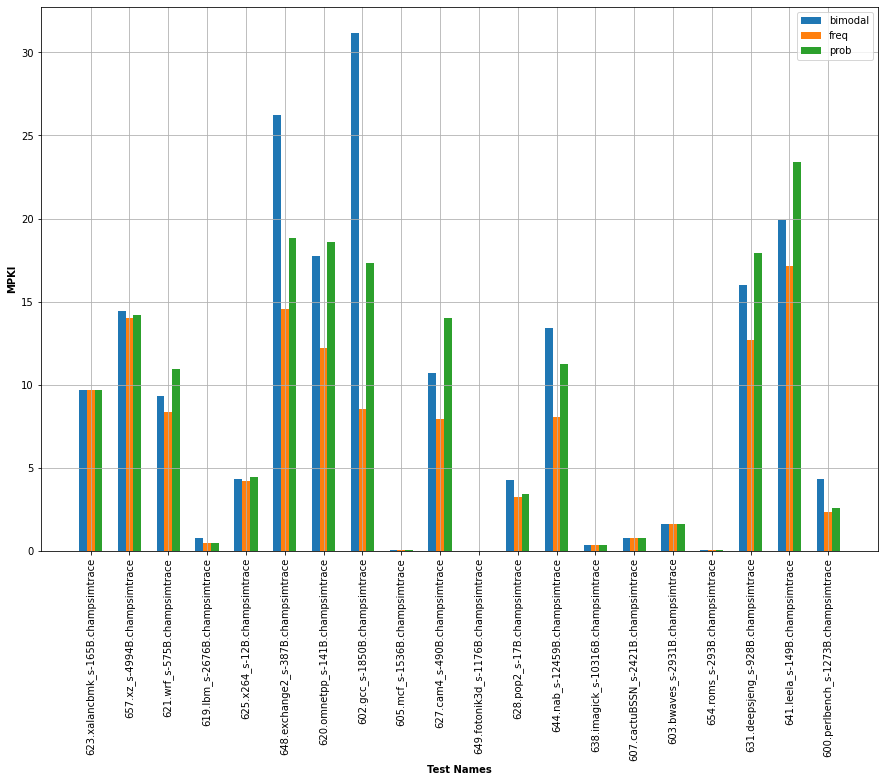

In [49]:

mpki_stats = dict(
    zip(
        stats,
        map(
            lambda v: dict(
                zip(v.stats, map(lambda x: x.mpki, v.stats.values()))
            ),
            stats.values(),
        ),
    )
)
ipc_stats = dict(
    zip(
        stats,
        map(
            lambda v: dict(
                zip(v.stats, map(lambda x: x.ipc, v.stats.values()))
            ),
            stats.values(),
        ),
    )
)
bar_w = 0.2
plt.figure(figsize=[15, 10])
for i, (pred, data) in enumerate(mpki_stats.items()):
    plt.bar(
        [r + bar_w * i for r in range(20)],
        data.values(),
        label=pred,
        width=bar_w,
    )
plt.xlabel("Test Names", fontweight="bold")
plt.ylabel("MPKI", fontweight="bold")
plt.xticks(
    [r + bar_w for r in range(20)],
    list(mpki_stats.values())[0].keys(),
    rotation=90,
)
plt.grid()
plt.legend()

По графику можно заметить, что частотный предиктор лучше предсказывает почти на всем наборе трасс (либо примерно так же как и остальные), в то время как бимодальный счетчик и вероятностный предсказатель ведут себя по-разному - где то лучше бимодальный, где то вероятностный. Возможно такое поведение может быть обусловлено случайной природой вероятностного счетчика (выбор предсказания осуществляется по распределению Бернулли, основанном на частноных данных).

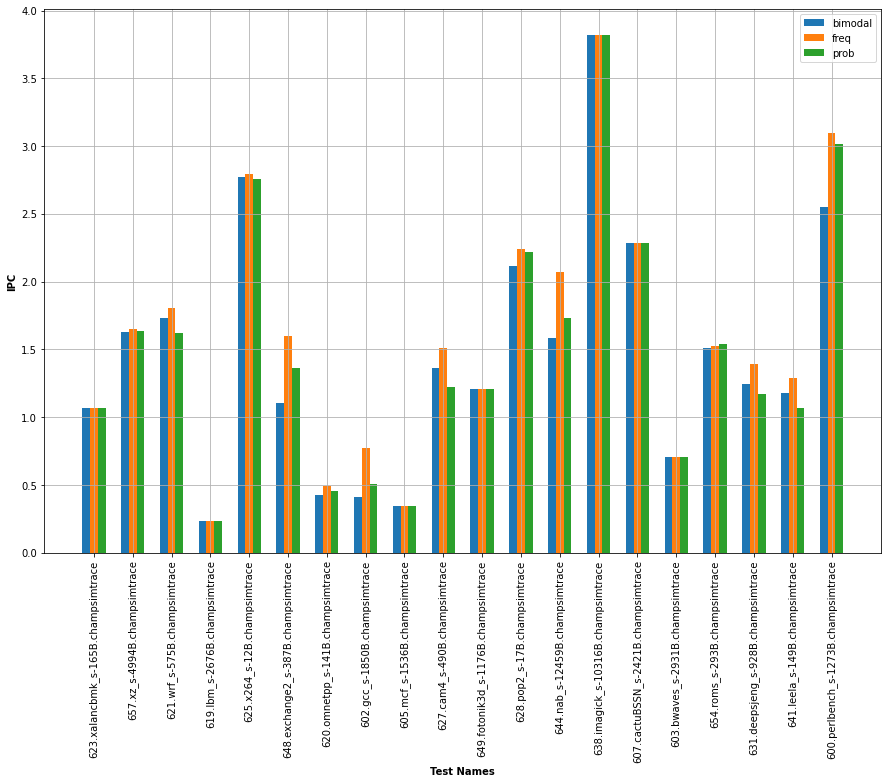

In [51]:
bar_w = 0.2
plt.figure(figsize=[15, 10])
for i, (pred, data) in enumerate(ipc_stats.items()):
    plt.bar(
        [r + bar_w * i for r in range(20)],
        data.values(),
        label=pred,
        width=bar_w,
    )
plt.xlabel("Test Names", fontweight="bold")
plt.ylabel("IPC", fontweight="bold")
plt.xticks(
    [r + bar_w for r in range(20)],
    list(ipc_stats.values())[0].keys(),
    rotation=90,
)
plt.grid()
plt.legend()

По IPC ситуация в целом аналогичная - частотный предиктор, засчёт более точных предскзаний, дает лучший показатель производительности

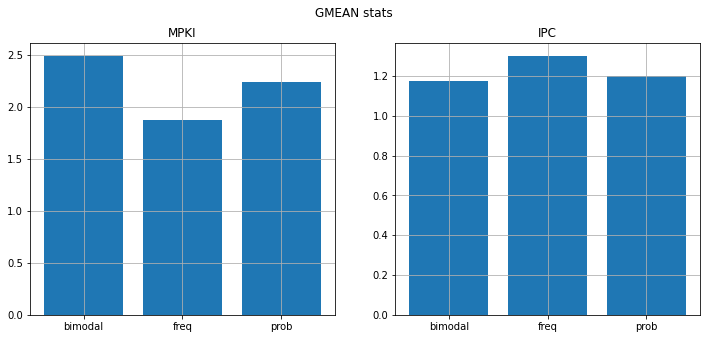

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
fig.suptitle("GMEAN stats")
ax1.set_title("MPKI")
ax1.bar(mpkis.keys(), mpkis.values())
ax1.grid()

ax2.set_title("IPC")
ax2.bar(ipcs.keys(), ipcs.values())
ax2.grid()

На графиках показаны Geomean статистик mpki и IPC. Можно заметить, что лучшие предсказания даёт частотный предиктор, на втором месте вероятностный предсказатель, на третьем бимодальный. 
Для IPC ситуация менее однозначная. Лучше всех себя показал опять частотный предсказатель, однако бимодальный и вероятностный предсказатели не сильно отличаются по производительности. Такой результат может быть связан с тем, что вероятностный предсказатель мог неверно предсказать (например в силу случайной природы) некоторые "дорогие" бранчи, вызывавшие сильный простой CPU из-за очистки ROB

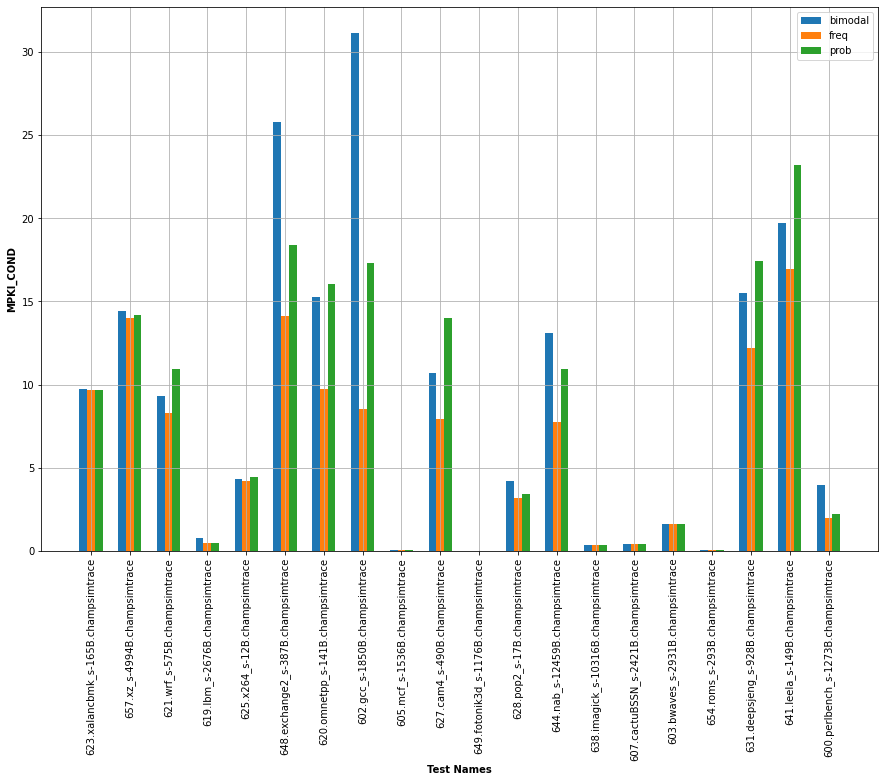

In [63]:
pred = ["bimodal", "freq", "prob"]
DIR = Path.cwd() / "results"
stat_dirs = [DIR / p for p in pred]
stats = defaultdict(dict)
for stat_dir in stat_dirs:
    for stat_file in stat_dir.iterdir():
        assert stat_file.suffix == ".json"
        with open(stat_file) as f:
            data = json.load(f)[0]["sim"]["cores"][0]
        mpki_cond = data["mispredict"]["BRANCH_CONDITIONAL"]
        stats[stat_dir.stem][stat_file.stem] = (
            mpki_cond * 1e3 / data["instructions"]
        )
mpki_stats = stats
bar_w = 0.2
plt.figure(figsize=[15, 10])
for i, (pred, data) in enumerate(mpki_stats.items()):
    plt.bar(
        [r + bar_w * i for r in range(20)],
        data.values(),
        label=pred,
        width=bar_w,
    )
plt.xlabel("Test Names", fontweight="bold")
plt.ylabel("MPKI_COND", fontweight="bold")
plt.xticks(
    [r + bar_w for r in range(20)],
    list(mpki_stats.values())[0].keys(),
    rotation=90,
)
plt.legend()
plt.grid()

При рассмотрении только conditional branches ситуация не меняется значительно

Avg ROB occupancy at mispredict: {'bimodal': 134.89204793529754, 'freq': 146.07604776821924, 'prob': 138.07368316869616}


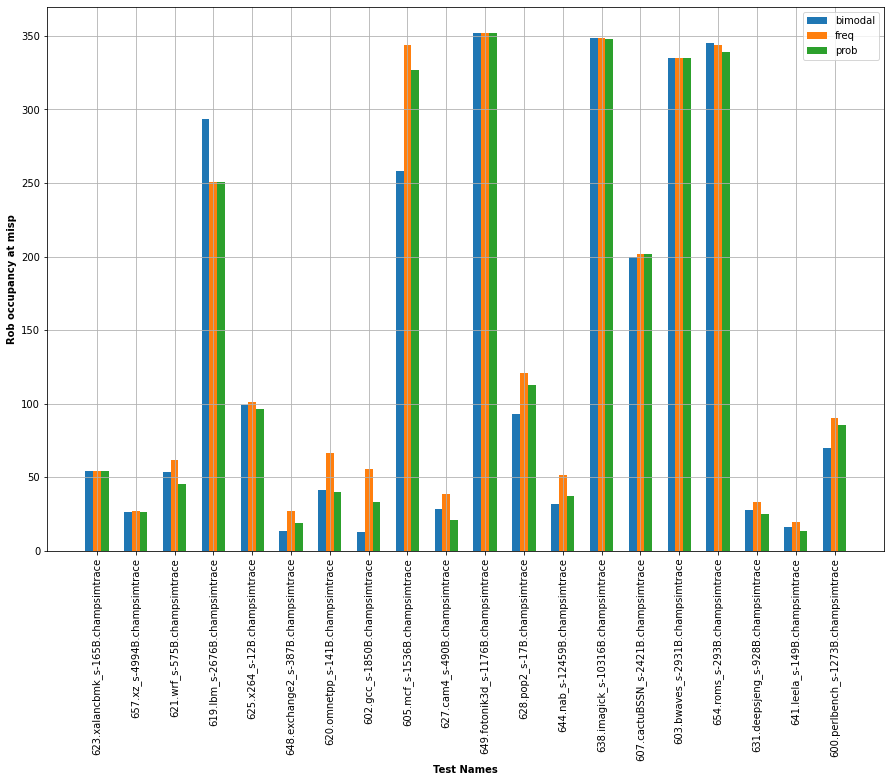

In [65]:
pred = ["bimodal", "freq", "prob"]
DIR = Path.cwd() / "results"
stat_dirs = [DIR / p for p in pred]
stats = defaultdict(dict)
for stat_dir in stat_dirs:
    for stat_file in stat_dir.iterdir():
        assert stat_file.suffix == ".json"
        with open(stat_file) as f:
            data = json.load(f)[0]["sim"]["cores"][0]
        rob = data["Avg ROB occupancy at mispredict"]
        stats[stat_dir.stem][stat_file.stem] = rob

bar_w = 0.2
plt.figure(figsize=[15, 10])
for i, (pred, data) in enumerate(stats.items()):
    plt.bar(
        [r + bar_w * i for r in range(20)],
        data.values(),
        label=pred,
        width=bar_w,
    )
plt.xlabel("Test Names", fontweight="bold")
plt.ylabel("Rob occupancy at misp", fontweight="bold")
plt.xticks(
    [r + bar_w for r in range(20)],
    list(stats.values())[0].keys(),
    rotation=90,
)
plt.legend()
plt.grid()
avgs = {k: np.mean(list(v.values())) for k, v in stats.items()}
print(f"Avg ROB occupancy at mispredict: {avgs}")

Если обратить внимание на заполненность ROB при неверном предсказании, то можно заметить, что она выше у вероятностного чем у бимодального, что подвтерждает предположение о том, что неверное предсказание стоило дороже для вероятностного